In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
from sklearn.model_selection import KFold
import numpy.random as npr
import robust_loss_pytorch
from robust_loss_pytorch import distribution
import robust_loss_pytorch.general as general
import random
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)



In [2]:
def train_regular(model, trX, trY, dist, learning_rate=0.01, epoch=500, verbose=True):

    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(dist.loss(y_hat, trY))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            # You can see the alpha+scale parameters moving around.
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model


def train_adaptive(model, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
        num_dims=1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
    params = list(model.parameters()) + list(adaptive.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(adaptive.lossfun((y_hat - trY)[:,None]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            e, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
    return model, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data


def train_locally_adaptive(model, alpha, scale, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    params = list(model.parameters()) + list(alpha.parameters()) + list(scale.parameters())
    dist = distribution.Distribution()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        alphas = torch.exp(alpha(trX))
        scales = torch.exp(scale(trX))
        loss = general.lossfun((y_hat - trY)[:, None], alpha=alphas, scale=scales, approximate=False)
        log_partition = torch.log(scales) + dist.log_base_partition_function(alphas)
        loss = (loss + log_partition).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model, alpha, scale


class PolyRegression(nn.Module):
    def __init__(self, dim, init_zeros=False):
        super(PolyRegression, self).__init__()
        self.beta = nn.Linear(dim, 1)
        self.n_poly = dim
        if init_zeros:
            with torch.no_grad():
                self.beta.weight.copy_(torch.zeros(dim))
                self.beta.bias.copy_(torch.zeros(1))

    def forward(self, x):
        """
        x: N x dim
        """
        expand = [(x**(i+1)).view(-1, 1) for i in range(self.n_poly)]
        expand = torch.cat(expand, dim=1)
        return self.beta(expand)


class AdaptiveRegression(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [3]:
class Gaussian(object):
    def loss(self, x, y):
        return (x-y)**2

    def loglikelihood(self, res, sigma=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if sigma is None:
            sigma = np.mean(res**2)
        N = len(res)
        ll = -N/2*np.log(2*np.pi*sigma) - 1/(2*sigma)*np.sum(res**2)
        return ll


class Laplace(object):
    def loss(self, x, y):
        return torch.abs(x-y)

    def loglikelihood(self, res, b=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if b is None:
            b = np.sqrt(np.mean(res ** 2)/2)
        N = len(res)
        ll = -N*np.log(2*b) - 1/b*np.sum(np.abs(res))
        return ll


class Adaptive(object):
    def loglikelihood(self, res, alpha, scale):
        assert alpha.view(-1).size()[0] == 1 or alpha.view(-1).size()[0] == len(res)
        N = len(res)
        dist = distribution.Distribution()
        loss = general.lossfun(res, alpha, scale, approximate=False).sum()
        log_partition = torch.log(scale) + dist.log_base_partition_function(alpha)
        if alpha.view(-1).size()[0] == 1:
            log_partition = N*log_partition
        else:
            log_partition = log_partition.sum()
        nll = loss + log_partition
        return -nll.detach().numpy()

    def sample(self, alpha, c):
        alpha = torch.as_tensor(alpha)
        scale = torch.as_tensor(c)
        assert (alpha >= 0).all()
        assert (scale >= 0).all()
        float_dtype = alpha.dtype
        assert scale.dtype == float_dtype

        cauchy = torch.distributions.cauchy.Cauchy(0., np.sqrt(2.))
        uniform = torch.distributions.uniform.Uniform(0, 1)
        samples = torch.zeros_like(alpha)
        accepted = torch.zeros(alpha.shape).type(torch.bool)
        dist = distribution.Distribution()
        while not accepted.type(torch.uint8).all():
            # Draw N samples from a Cauchy, our proposal distribution.
            cauchy_sample = torch.reshape(
              cauchy.sample((np.prod(alpha.shape),)), alpha.shape)
            cauchy_sample = cauchy_sample.type(alpha.dtype)

            # Compute the likelihood of each sample under its target distribution.
            nll = dist.nllfun(cauchy_sample,
                            torch.as_tensor(alpha).to(cauchy_sample),
                            torch.tensor(1).to(cauchy_sample))

            # Bound the NLL. We don't use the approximate loss as it may cause
            # unpredictable behavior in the context of sampling.
            nll_bound = general.lossfun(
              cauchy_sample,
              torch.tensor(0., dtype=cauchy_sample.dtype),
              torch.tensor(1., dtype=cauchy_sample.dtype),
              approximate=False) + dist.log_base_partition_function(alpha)

            # Draw N samples from a uniform distribution, and use each uniform sample
            # to decide whether or not to accept each proposal sample.
            uniform_sample = torch.reshape(
              uniform.sample((np.prod(alpha.shape),)), alpha.shape)
            uniform_sample = uniform_sample.type(alpha.dtype)
            accept = uniform_sample <= torch.exp(nll_bound - nll)

            # If a sample is accepted, replace its element in `samples` with the
            # proposal sample, and set its bit in `accepted` to True.
            samples = torch.where(accept, cauchy_sample, samples)
            accepted = accepted | accept

            # Because our distribution is a location-scale family, we sample from
            # p(x | 0, \alpha, 1) and then scale each sample by `scale`.
            samples *= scale
        return samples

In [4]:
# GP
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=1),
            ), grid_size=grid_size, num_dims=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Heteroskedastic data: LIDAR

c:\users\cecilia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


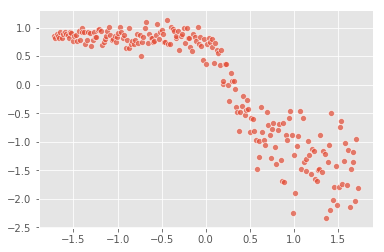

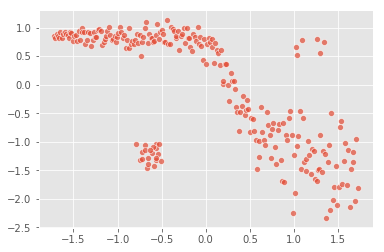

In [5]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']

x_range = np.array((x_range-np.mean(x_range))/np.std(x_range))
y_ratio = np.array((y_ratio-np.mean(y_ratio))/np.std(y_ratio))
sns.scatterplot(x_range, y_ratio, alpha=0.7)
plt.show()

x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(20,))
y_out1 = np.random.uniform(low=-1.5, high=-1, size=(20,))
x_out2 = np.random.uniform(low=1, high=1.5, size=(6,))
y_out2 = np.random.uniform(low=0.5, high=1, size=(6,))

x_range_out = np.concatenate((x_range,x_out1), axis=0)
x_range_out = np.concatenate((x_range_out,x_out2), axis=0)
y_ratio_out = np.concatenate((y_ratio,y_out1), axis=0)
y_ratio_out = np.concatenate((y_ratio_out,y_out2), axis=0)
sns.scatterplot(x_range_out, y_ratio_out, alpha=0.7)

# Heteroskedastic data: MOTOR

In [ ]:
X = pd.read_csv('../dataset/mcycle.csv')
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)

x_out1 = np.random.uniform(low=-1.5, high=-1, size=(4,))
y_out1 = np.random.uniform(low=-1, high=-1.4, size=(4,))
x_out2 = np.random.uniform(low=1.3, high=1.5, size=(5,))
y_out2 = np.random.uniform(low=-1, high=-1.5, size=(5,))

x_motor_out = np.concatenate((x_motor,x_out1), axis=0)
x_motor_out = np.concatenate((x_motor_out,x_out2), axis=0)
y_motor_out = np.concatenate((y_motor,y_out1), axis=0)
y_motor_out = np.concatenate((y_motor_out,y_out2), axis=0)

sns.scatterplot(x_motor, y_motor, alpha=0.7)
plt.show()

sns.scatterplot(x_motor_out, y_motor_out, alpha=0.7)
plt.show()

In [6]:
dataset = 'lidar'   #'motor'
outliers = True

if outliers:
    x_range, y_ratio = x_range_out, y_ratio_out

if dataset=='lidar':
    if outliers:
        x_range, y_ratio = x_range_out, y_ratio_out
    trX, teX, trY, teY = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
elif dataset=='motor':
    if outliers:
        x_motor, y_motor = x_motor_out, y_motor_out
    trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

In [7]:
print(trX.shape, trY.shape)

(172,) (172,)


In [15]:
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

## Polynomial regression with regular, adaptive and locally adaptive

In [ ]:
x, y = torch.Tensor(trX), torch.Tensor(trY)

# define regression degree
reg_degree = 5

# define regression model
lr = PolyRegression(reg_degree)

# regular loss training
reg_fit = train_regular(lr, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

# ada loss training
ada_fit, alpha, scale = train_adaptive(lr, x, y, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
alpha_model = PolyRegression(5, init_zeros=True)
scale_model = PolyRegression(5, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, x,y, learning_rate=0.01, epoch=500, verbose=False)

# 5-fold cross-validation for model degree

In [16]:
x, y = torch.Tensor(trX), torch.Tensor(trY)

n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=3)

reg_degrees = 3

table = np.zeros((reg_degrees, 4))

for i in range(reg_degrees):
    
    reg_degree = i+1
    print(reg_degree)
    
    
    gauss_log_likelihoods = np.zeros((n_splits,1))
    laplace_log_likelihoods = np.zeros((n_splits,1))
    ada_log_likelihoods = np.zeros((n_splits,1))
    adaloc_log_likelihoods = np.zeros((n_splits,1))
    
    j = 0

    for train_index, test_index in cv.split(x):
            
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # define regression model
        lr = PolyRegression(reg_degree)

        # regular loss training - gaussian
        reg_fit = train_regular(lr, X_train, y_train, gaussian, epoch=500, learning_rate=0.01, verbose=False)
        
        # regular loss training - laplace
        reg_fit_laplace = train_regular(lr, X_train, y_train, laplace, epoch=500, learning_rate=0.01, verbose=False)

        # ada loss training
        ada_fit, alpha, scale = train_adaptive(lr, X_train, y_train, learning_rate=0.01, epoch=500, verbose=False)

        # adalocal loss training
        alpha_model = PolyRegression(2, init_zeros=True)
        scale_model = PolyRegression(2, init_zeros=True)
        ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, X_train, y_train, 
                                                                   learning_rate=0.01, epoch=500, verbose=False)
                

        sortedx, idxX = torch.sort(X_test)
        y2 = reg_fit(sortedx).detach().view(-1)
        ylap = reg_fit_laplace(sortedx).detach().view(-1)
        yar = ada_fit(sortedx).detach().view(-1)
        yalr = ada_loc_fit(sortedx).detach().view(-1)
        alphas = torch.exp(alpha_model(sortedx).view(-1))
        scales = torch.exp(scale_model(sortedx).view(-1))
        
        gauss_log_lik = gaussian.loglikelihood(y2.numpy().flatten()-y_test.numpy().flatten())
        laplace_log_lik = laplace.loglikelihood(ylap.numpy().flatten()-y_test.numpy().flatten())
        ada_log_lik = adaptive.loglikelihood(yar-y_test[idxX], alpha, scale)
        adaloc_log_lik = adaptive.loglikelihood(yalr-y_test[idxX], alphas, scales)
        
        gauss_log_likelihoods[j,:] = gauss_log_lik
        laplace_log_likelihoods[j,:] = laplace_log_lik
        ada_log_likelihoods[j,:] = ada_log_lik
        adaloc_log_likelihoods[j,:] = adaloc_log_lik

        print('Polynomial degree ', reg_degree)
        print('Gaussian Log Likelihood: ', gaussian.loglikelihood(y2.numpy().flatten()-y_test.numpy().flatten()))
        print('Laplace Log Likelihood: ', laplace.loglikelihood(ylap.numpy().flatten()-y_test.numpy().flatten()))
        print('Adaptive Log Likelihood: ', adaptive.loglikelihood(yar-y_test[idxX], alpha, scale))
        print('Ada+reg Log Likelihood : ', adaptive.loglikelihood(yalr-y_test[idxX], alphas, scales))
        
        sns.scatterplot(trX, trY, alpha=0.2)
        sns.lineplot(sortedx.detach().numpy(), y2.detach().numpy().flatten(), label='regular')
        sns.lineplot(sortedx.detach().numpy(), yar.detach().numpy().flatten(), label='adaptive robust 2d')
        sns.lineplot(sortedx.detach().numpy(), yalr.detach().numpy().flatten(), label='adaptive robust 2d + regression')
        plt.show()
        
        j += 1
    
    gauss_log_likelihood_mean = np.mean(gauss_log_likelihoods)
    laplace_log_likelihood_mean = np.mean(laplace_log_likelihoods)
    ada_log_likelihood_mean = np.mean(ada_log_likelihoods)
    adaloc_log_likelihood_mean = np.mean(adaloc_log_likelihoods)
    
    table[i, 0] = gauss_log_likelihood_mean
    table[i, 1] = laplace_log_likelihood_mean
    table[i, 2] = ada_log_likelihood_mean
    table[i, 3] = adaloc_log_likelihood_mean
    
    
    

1


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 222.02it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -59.160824712270355
Laplace Log Likelihood:  -64.00998156766593
Adaptive Log Likelihood:  -40.218773
Ada+reg Log Likelihood :  -36.03088


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 182.55it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -59.58151930919855
Laplace Log Likelihood:  -59.97047265715476
Adaptive Log Likelihood:  -41.915302
Ada+reg Log Likelihood :  -34.714848


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 249.75it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -53.17663983940809
Laplace Log Likelihood:  -53.767374097543716
Adaptive Log Likelihood:  -31.946724
Ada+reg Log Likelihood :  -26.821606


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.41it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -50.34372330635793
Laplace Log Likelihood:  -53.94769893592622
Adaptive Log Likelihood:  -34.67273
Ada+reg Log Likelihood :  -30.753407


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 261.52it/s]


Polynomial degree  1
Gaussian Log Likelihood:  -51.640886971461626
Laplace Log Likelihood:  -55.178652319398296
Adaptive Log Likelihood:  -39.781815
Ada+reg Log Likelihood :  -38.951557
2


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 257.86it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -63.761330506567816
Laplace Log Likelihood:  -66.09100614838499
Adaptive Log Likelihood:  -44.31858
Ada+reg Log Likelihood :  -32.456024


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.26it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -61.55854701013201
Laplace Log Likelihood:  -58.601845360776
Adaptive Log Likelihood:  -40.37597
Ada+reg Log Likelihood :  -20.91999


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 253.42it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -57.516191149926485
Laplace Log Likelihood:  -54.99082610508063
Adaptive Log Likelihood:  -29.420883
Ada+reg Log Likelihood :  -12.875006


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 245.34it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -52.47785826538249
Laplace Log Likelihood:  -52.48093361147358
Adaptive Log Likelihood:  -34.013107
Ada+reg Log Likelihood :  -19.481636


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 231.37it/s]


Polynomial degree  2
Gaussian Log Likelihood:  -53.844950472488264
Laplace Log Likelihood:  -55.658227393611085
Adaptive Log Likelihood:  -40.20975
Ada+reg Log Likelihood :  -33.396507
3


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 258.83it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -63.86756019613739
Laplace Log Likelihood:  -66.15035117739555
Adaptive Log Likelihood:  -43.04156
Ada+reg Log Likelihood :  -32.165794


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 254.84it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -62.05060607793598
Laplace Log Likelihood:  -58.92158065758565
Adaptive Log Likelihood:  -41.812637
Ada+reg Log Likelihood :  -21.29466


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.41it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -58.13113122736228
Laplace Log Likelihood:  -55.58699379593462
Adaptive Log Likelihood:  -28.911015
Ada+reg Log Likelihood :  -13.462759


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 256.28it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -52.70498174317559
Laplace Log Likelihood:  -52.514351596025435
Adaptive Log Likelihood:  -34.53428
Ada+reg Log Likelihood :  -19.254578


100%|███████████████████████████████████████| 500/500 [00:01<00:00, 260.01it/s]


Polynomial degree  3
Gaussian Log Likelihood:  -54.084434099300196
Laplace Log Likelihood:  -55.92209040358766
Adaptive Log Likelihood:  -40.065876
Ada+reg Log Likelihood :  -33.652626


In [ ]:
np.round(table, 2)   #col 0: gaussian, col 1: ada, col 2: adaloc

# GP baseline

In [10]:
# GP regression
x, y = torch.Tensor(trX), torch.Tensor(trY)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x, y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50
for i in tqdm(range(training_iter)):
    optimizer.zero_grad()
    output = model(x)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()
    


100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 29.08it/s]


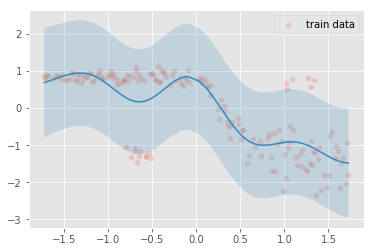

In [12]:
sortedx, idxX = torch.sort(x)
sortedy = y[idxX]

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sortedx))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(trX, trY, label='train data', alpha=0.2)
    sns.lineplot(sortedx, observed_pred.mean.numpy(), color=palette[1])
    plt.fill_between(sortedx.detach(), lower.numpy(), upper.numpy(), alpha=0.2)

In [13]:
mll(observed_pred, y)*len(y)

tensor(-279.5622, grad_fn=<MulBackward0>)